#### Imports

In [1]:
project_root_dir = "../../../"

import os
work_dir = os.path.abspath(project_root_dir)

import sys
sys.path.append(project_root_dir)

import wandb
import re

import pandas as pd
from IPython.display import display, HTML
from functools import reduce

import numpy as np

from src.utils import evaluation_helpers
from src.datamodules import IEGenericOutputDataset

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_style("ticks")
sns.set_palette("deep")

In [2]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

## The Part to Update

In [3]:
# api = wandb.Api()
# entity, project = "martinj96", "SynthIE"  # set to your entity and project 
# runs = api.runs(entity + "/" + project) 
# run_name2wandb_path = {}
# for run in runs:
#     run_name2wandb_path[run.name] = f"{entity}/{project}/{run.id}"
#     if run.name == 'v2_rebel_cw-genie_split-test_20_cm-R-max_lp-0.7':
#         break
# print(run_name2wandb_path)

run_name2wandb_path = {'v3_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-free_lp-1.0': 'martinj96/SynthIE/3ena24p7',
 'v2_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-free_lp-1.0': 'martinj96/SynthIE/39mh4po4',
 'v3_rebel_cw-genie_split-test_20_cm-free_lp-1.0': 'martinj96/SynthIE/2ryp8891',
 'v2_rebel_cw-genie_split-test_20_cm-free_lp-1.0': 'martinj96/SynthIE/30dqfqvp',
 'v3_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-free_lp-0.8': 'martinj96/SynthIE/2hlnoazf',
 'v2_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-free_lp-0.8': 'martinj96/SynthIE/31mlpatu',
 'v3_rebel_cw-genie_split-test_20_cm-free_lp-0.8': 'martinj96/SynthIE/1w4cry91',
 'v2_rebel_cw-genie_split-test_20_cm-free_lp-0.8': 'martinj96/SynthIE/1k263xsl',
 'v3_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-free_lp-0.7': 'martinj96/SynthIE/3icezta5',
 'v2_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-free_lp-0.7': 'martinj96/SynthIE/214010dm',
 'v3_rebel_cw-genie_split-test_20_cm-free_lp-0.7': 'martinj96/SynthIE/3dq94zw8',
 'v2_rebel_cw-genie_split-test_20_cm-free_lp-0.7': 'martinj96/SynthIE/3ioya2ri',
 'v3_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-R-max_lp-1.0': 'martinj96/SynthIE/33fpno7j',
 'v2_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-R-max_lp-1.0': 'martinj96/SynthIE/qczn60xm',
 'v3_rebel_cw-genie_split-test_20_cm-R-max_lp-1.0': 'martinj96/SynthIE/mna2olfm',
 'v2_rebel_cw-genie_split-test_20_cm-R-max_lp-1.0': 'martinj96/SynthIE/2tq4j5j2',
 'v3_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-R-max_lp-0.8': 'martinj96/SynthIE/ht2eevgz',
 'v2_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-R-max_lp-0.8': 'martinj96/SynthIE/m7e4caxo',
 'v3_rebel_cw-genie_split-test_20_cm-R-max_lp-0.8': 'martinj96/SynthIE/ixojr0qq',
 'v2_rebel_cw-genie_split-test_20_cm-R-max_lp-0.8': 'martinj96/SynthIE/u8duodwj',
 'v3_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-R-max_lp-0.7': 'martinj96/SynthIE/22djwbxk',
 'v2_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-R-max_lp-0.7': 'martinj96/SynthIE/3274th6j',
 'v3_rebel_cw-genie_split-test_20_cm-R-max_lp-0.7': 'martinj96/SynthIE/2f857wrl',
 'v2_rebel_cw-genie_split-test_20_cm-R-max_lp-0.7': 'martinj96/SynthIE/izr0vgpw'}

# Used for the process_results launcher
# print(" ".join(list(run_name2wandb_path.values())))

In [4]:
#### Which experiments to consider?

# model_id_wandb_run_path_pairs = [("R", "martinj96/SynthIE/izr0vgpw"), ("R+S", "martinj96/SynthIE/2f857wrl"), ("R", "martinj96/SynthIE/3274th6j"), ("R+S", "martinj96/SynthIE/runs/22djwbxk")]
model_id_wandb_run_path_pairs = [("R", wandb_path) if run_name.startswith("v2") else ("R+S", wandb_path) for run_name, wandb_path in run_name2wandb_path.items()][::-1]

#### What to report?

PRESENT_QUANTITATIVE_RESULTS = True
PRESENT_QUALITATIVE_RESULTS = False


# ~~~ Qauntitative results ~~~
metrics = ["triplet_set_precision", "triplet_set_recall", "triplet_set_f1"]
# Used for the confidence interval retrieval from the results.json file
n_bootstrap_samples = 50  # Set to None to present only the corpus level metric (without confidence intervals)
confidence_level = 0.95

metric_name2label = {"triplet_set_precision": "P", "triplet_set_recall": "R", "triplet_set_f1": "F1"}
dataset_name2dataset_label = {"rebel": "REBEL", "sdg_code_davinci_002": "[SDG] Code Davinci"}
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# ~~~ Qualitative results ~~~
n_samples = 20
n_predictions_to_show = 1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

##### Define Experiment ID

In [5]:
# ~~~ Optional ~~~~
def retrieve_constraint_module_id(hydra_config):
    cm_cfg = hydra_config['model']['constraint_module']

    if cm_cfg == None or cm_cfg == 'None':
        return "free"

    identifier2label = {'genie': 'R-max'}
    return identifier2label.get(cm_cfg['identifier'], cm_cfg['identifier'])

def retrieve_lenght_penalty(hydra_config):
    return hydra_config['model']['hparams_overrides']['inference']['hf_generation_params']['length_penalty']
# ~~~~~~~~~~~~~~~~~~

# The names of these functions should not change    
def get_exp_id(model_id, hydra_config):
    return f"{model_id} -- ({retrieve_constraint_module_id(hydra_config)}) lp_{retrieve_lenght_penalty(hydra_config)} [{dataset_name2dataset_label[retrieve_dataset_name(hydra_config)]}]"

def retrieve_dataset_name(hydra_config):
    return hydra_config['datamodule']['name']

results_df_field2getter = {"LP": retrieve_lenght_penalty, "Constraint": retrieve_constraint_module_id}
barplot_hue_ordering = ['Model', 'LP', 'Constraint']

results_df_field2getter = {"LP": retrieve_lenght_penalty, "Constraint": retrieve_constraint_module_id}
results_ordering = barplot_hue_ordering = ['Model', 'LP', 'Constraint']

## Main Part

In [6]:
wandb_configs = {}
hydra_configs = {}
abs_exp_dirs = {}

output_datasets = {}
results = {}

exp_id2wandb_run_path = {}
exp_id2model_id = {}

for model_id, wandb_run_path in model_id_wandb_run_path_pairs:
    api = wandb.Api()
    run = api.run(wandb_run_path)
    wandb_config, hydra_config, abs_exp_dir = evaluation_helpers.prepare_data_for_experiment(wandb_run_path, work_dir, print)
    exp_id = get_exp_id(model_id, hydra_config)
    exp_id2wandb_run_path[exp_id] = wandb_run_path
    exp_id2model_id[exp_id] = model_id

    wandb_configs[exp_id], hydra_configs[exp_id], abs_exp_dirs[exp_id] = wandb_config, hydra_config, abs_exp_dir

    # Load predictions data
    data_dir = os.path.join(abs_exp_dirs[exp_id], "predictions")
    output_datasets[exp_id] = IEGenericOutputDataset(data_dir=data_dir, seed=123)

    # Load existing results data
    results[exp_id] = evaluation_helpers.Results(abs_exp_dirs[exp_id])

exp_ids = list(results.keys())

Experiment directory already exists: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/v2_rebel_cw-genie_split-test_20_cm-R-max_lp-0.7/2023-01-09_21-18-46
Loading the existing results
Experiment directory already exists: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/v3_rebel_cw-genie_split-test_20_cm-R-max_lp-0.7/2023-01-09_21-20-55
Loading the existing results
Experiment directory already exists: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/v2_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-R-max_lp-0.7/2023-01-09_21-23-36
Loading the existing results
Experiment directory already exists: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/v3_sdg_code_davinci_002_cw-genie_split-test_code_davinci_20_cm-R-max_lp-0.7/2023-01-09_21-25-35
Loading the existing results
Experiment directory already exists: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/v2_rebel_cw-genie_split-test_20_cm-R-max_lp-0.8/2023-01-

In [7]:
if PRESENT_QUANTITATIVE_RESULTS:
    metric_label = [metric_name2label[metric_id] for metric_id in metrics]

    # Retrieve information
    results_dfs = []
    for exp_id in exp_id2wandb_run_path.keys():
        curr_results = results[exp_id]
        
        if n_bootstrap_samples is None:
            y = [curr_results.get_corpus_level_metric(metric_id) for metric_id in metrics]
            yerr = None
        else:
            y = []
            yerr = []
            for metric_id in metrics:
                ci = curr_results.get_ci(metric_id, confidence_level, n_bootstrap_samples)
                y.append(ci['mean'])
                yerr.append((ci['mean'] - ci['lower'], ci['upper'] - ci['mean']))

            yerr = np.array(yerr).T

        # create a datataframe
        df = pd.DataFrame({'Metric': metric_label, 'Score': y, 'ci_score_lower': yerr[0, :], 'ci_score_upper': yerr[1, :]})
        
        # required fields
        df['Exp_ID'] = [exp_id] * df.shape[0]
        df['Dataset'] = [retrieve_dataset_name(hydra_configs[exp_id])] * df.shape[0]
        df['Model'] = [exp_id2model_id[exp_id]] * df.shape[0]

        # optional fields
        if results_df_field2getter is not None:
            for field_name, getter in results_df_field2getter.items():
                df[field_name] = [getter(hydra_configs[exp_id])] * df.shape[0]
        results_dfs.append(df)

    results_df = pd.concat(results_dfs, axis=0)
    
    # Massage the data
    dataset_names = results_df['Dataset'].unique()

    per_dataset_results_long = {}
    per_dataset_results_wide = {}

    per_dataset_results_ci_lower = {}
    per_dataset_results_ci_upper = {}

    for dataset_name in dataset_names:
        dataset_long_df = results_df[results_df['Dataset'] == dataset_name].copy()
        # set the error term to the average of the empirical lower and upper confidence interval delta
        # dataset_long_df['Error'] = ((dataset_long_df['ci_score_lower'] + dataset_long_df['ci_score_upper']) / 2)
        # dataset_long_df['Score_with_ci'] = (dataset_long_df['Score']*100).round(2).astype(str) + ' ± ' + (dataset_long_df['Error']*100).round(2).astype(str)
        dataset_long_df['Score_with_ci'] = (dataset_long_df['Score']*100).round(2).astype(str) + " [" + ((dataset_long_df['Score']-dataset_long_df['ci_score_lower'])*100).round(2).astype(str) + ", " + ((dataset_long_df['Score'] + dataset_long_df['ci_score_upper'])*100).round(2).astype(str) + "]"
        per_dataset_results_long[dataset_name] = dataset_long_df

        pivot_index = ['Model']
        if results_df_field2getter is not None:
            pivot_index.extend(list(results_df_field2getter.keys()))
        dataset_wide_df = dataset_long_df.pivot_table(index=pivot_index, columns='Metric', values='Score_with_ci', aggfunc=lambda x: ' '.join(x))
        dataset_wide_df = dataset_wide_df[['P', 'R', 'F1']]
        per_dataset_results_wide[dataset_name] = dataset_wide_df

    results_wide_df = pd.concat(per_dataset_results_wide.values(), keys=per_dataset_results_wide.keys(), names=['Dataset'], axis=1)
    results_wide_df = results_wide_df.sort_index(axis=0, level=results_ordering)
    results_wide_df.columns = pd.MultiIndex.from_tuples([(dataset_name2dataset_label[dataset_name], metric) for dataset_name, metric in results_wide_df.columns.values], names=['Dataset', f'Metric [{int(confidence_level*100)}% CI]'])
    
    display(results_wide_df)

Dataset                              REBEL                        \
Metric [95% CI]                          P                     R   
Model LP  Constraint                                               
R     0.7 R-max       67.19 [49.26, 84.26]  66.62 [53.29, 77.97]   
          free        65.69 [42.75, 80.83]  63.78 [44.41, 77.24]   
      0.8 R-max       67.19 [49.26, 84.26]  66.62 [53.29, 77.97]   
          free        64.08 [41.23, 79.42]  63.78 [44.41, 77.24]   
      1.0 R-max        55.87 [27.55, 78.4]   66.76 [49.05, 80.0]   
          free        59.87 [38.76, 75.19]  63.78 [44.41, 77.24]   
R+S   0.7 R-max          8.78 [4.23, 12.5]   18.64 [10.12, 27.8]   
          free         10.29 [4.68, 15.18]  20.75 [11.75, 29.92]   
      0.8 R-max         9.43 [3.84, 13.85]  22.33 [11.42, 31.82]   
          free         11.75 [5.37, 17.63]   24.44 [13.63, 37.5]   
      1.0 R-max         7.78 [3.09, 11.09]  22.33 [11.42, 31.82]   
          free          11.0 [6.38, 16.31]   27.8 [15.23, 40.44]   

Dataset                                       [SDG] Code Davinci  \
Metric [95% CI]                         F1                     P   
Model LP  Constraint                                               
R     0.7 R-max       66.74 [51.17, 79.84]   18.51 [4.59, 34.88]   
          free        64.61 [43.82, 77.06]    14.3 [0.94, 28.57]   
      0.8 R-max       66.74 [51.17, 79.84]   18.51 [4.59, 34.88]   
          free        63.82 [43.19, 76.03]    14.3 [0.94, 28.57]   
      1.0 R-max       60.43 [35.74, 77.62]    21.7 [4.65, 41.76]   
          free        61.56 [41.71, 74.23]   17.03 [0.94, 38.23]   
R+S   0.7 R-max        11.86 [5.98, 16.59]  90.35 [83.28, 96.94]   
          free          13.7 [6.78, 19.05]  80.01 [64.92, 89.48]   
      0.8 R-max         13.2 [5.74, 18.83]  87.55 [79.59, 92.64]   
          free          15.8 [7.82, 23.58]  78.99 [63.32, 88.61]   
      1.0 R-max        11.48 [4.86, 16.68]  85.21 [75.97, 92.07]   
          free         15.69 [9.17, 22.43]  75.35 [60.54, 86.67]   

Dataset                                                           
Metric [95% CI]                          R                    F1  
Model LP  Constraint                                              
R     0.7 R-max           4.17 [0.9, 9.55]    6.79 [1.51, 14.77]  
          free            3.35 [0.2, 9.13]     5.41 [0.34, 13.8]  
      0.8 R-max           4.17 [0.9, 9.55]    6.79 [1.51, 14.77]  
          free            3.35 [0.2, 9.13]     5.41 [0.34, 13.8]  
      1.0 R-max          5.28 [0.9, 14.12]     8.45 [1.5, 20.87]  
          free           4.45 [0.2, 13.06]    7.03 [0.34, 19.84]  
R+S   0.7 R-max       62.14 [56.38, 70.21]  73.58 [68.19, 80.23]  
          free        55.19 [41.96, 66.11]  65.28 [50.67, 75.16]  
      0.8 R-max       62.14 [56.38, 70.21]  72.63 [66.67, 79.37]  
          free        55.19 [41.96, 66.11]  64.93 [50.38, 75.06]  
      1.0 R-max       65.18 [59.46, 72.82]   73.8 [68.27, 81.31]  
          free        57.72 [45.71, 67.29]  65.33 [52.98, 75.76]

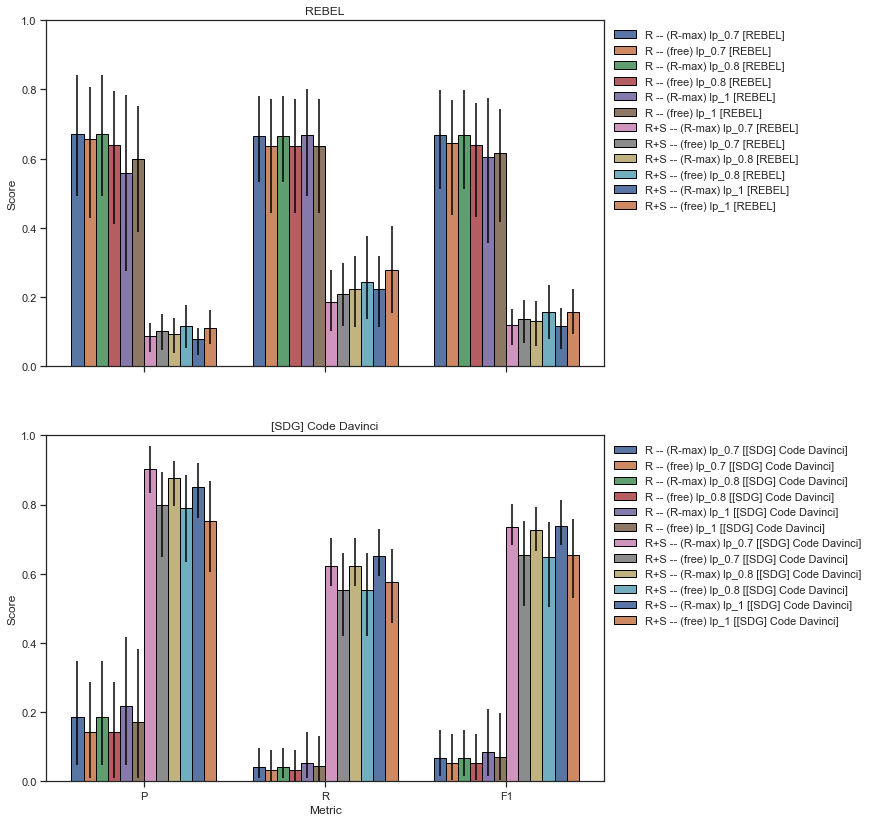

In [8]:
# Figure for the table above
if PRESENT_QUANTITATIVE_RESULTS:
    capsize = 0

    # get a subplot for each dataset
    figsize = (10, 7 * len(dataset_names))
    fig, axes = plt.subplots(len(dataset_names), 1, figsize=figsize, sharex=True, sharey=True)
    
    if len(dataset_names) == 1:
        axes = [axes]

    for ax, dataset_name in zip(axes, dataset_names):
        dataset_results_long_df = per_dataset_results_long[dataset_name]
        # sort the dataframe accoring to the Constraint, Model and LP
        if barplot_hue_ordering is not None:
            dataset_results_long_df = dataset_results_long_df.sort_values(by=barplot_hue_ordering)
        dataset_results_long_df.reset_index(inplace=True, drop=True)

        hue_order = dataset_results_long_df['Exp_ID'].drop_duplicates().values.tolist()
        order = ['P', 'R', 'F1']
        sns.barplot(ax=ax, data=dataset_results_long_df, x='Metric', y="Score", hue='Exp_ID', edgecolor="black", palette='deep', order=order, hue_order=hue_order)

        ax.set_title(dataset_name2dataset_label[dataset_name])
        ax.set_ylabel("Score")
        ax.set_ylim(0,1)
        if ax != axes[0]:
            ax.set_xlabel("Metric")
        else:
            ax.set_xlabel("")

        # make the legend a bit more compact and remove the box around the legend
        # handles, labels = ax.get_legend_handles_labels()
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, frameon=False)

        if 'ci_score_lower' in dataset_results_long_df.columns:
            x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
            y_coords = [p.get_height() for p in ax.patches]

            dataset_results_long_df.Exp_ID = pd.Categorical(dataset_results_long_df.Exp_ID, categories=hue_order, ordered=True)
            dataset_results_long_df.Metric = pd.Categorical(dataset_results_long_df.Metric, categories=order, ordered=True)
            error = np.stack([dataset_results_long_df.sort_values(by=['Exp_ID', 'Metric'])['ci_score_lower'].values, dataset_results_long_df.sort_values(by=['Exp_ID', 'Metric'])['ci_score_upper'].values])
            ax.errorbar(x=x_coords, y=y_coords, yerr=error, fmt="none", color="black", capsize=capsize, zorder=10000)

In [10]:
def get_predictions_df(exp_ids):
        random_ids = None

        pred_dfs = []

        for exp_id in exp_ids:
            output_dataset = output_datasets[exp_id]

            
            if random_ids is None:
                random_indices = np.random.RandomState(seed).choice(len(output_dataset),  min([n_samples, len(output_dataset)]), replace=False)
                random_ids = set([output_dataset.data[i]['id'] for i in random_indices])

            random_sample = [output_dataset.data[i] for i in random_indices if output_dataset.data[i]['id'] in random_ids]

            ids = [sample['id'] for sample in random_sample]
            inputs = [sample['input'] for sample in random_sample]
            targets = [sample['target'] for sample in random_sample]
            predictions = [sample['prediction'][0] if n_predictions_to_show == 1 else sample['prediction'][:n_predictions_to_show] for sample in random_sample]

            df = pd.DataFrame(list(zip(ids, inputs, targets, predictions)), columns=['id', 'input', 'target', f'prediction_{exp_id}'])
            pred_dfs.append(df)

        predictions_df = reduce(lambda  left,right: pd.merge(left,right,on=['id', 'input', 'target'], how='inner', ), pred_dfs)
        predictions_df.sort_values(by=['id'], inplace=True)
        assert(predictions_df.shape[0] == len(random_ids))
        return predictions_df


def wrap_df_text(df, input_max_col):
    tdf = df.copy()
    tdf['input'] = tdf['input'].str.wrap(input_max_col)
    tdf['target'] = tdf['target'].str.replace("\[e\]|\[et\]", "[e]\\n", regex=True)

    for col in tdf.columns:
        if col.startswith("prediction"):
            if type(tdf[col][0]) == str:
                tdf[col] = tdf[col].str.replace("\[e\]|\[et\]", "[e]\\n", regex=True)
            else:
                tdf[col] = tdf[col].apply(lambda x: "\\n".join([re.sub("\[e\]|\[et\]", "[e]\\n", p) for p in x]))

    display(HTML(tdf.to_html().replace("\\n","<br>")))

        

if PRESENT_QUALITATIVE_RESULTS:
    seed = 123

    # get the dataset_name for each experiment
    dataset_names = list([retrieve_dataset_name(hydra_configs[exp_id]) for exp_id in exp_ids])

    for dataset_name in set(dataset_names):
        print(f"~~~~ {dataset_name2dataset_label[dataset_name]} ~~~~")
        exp_ids_to_visualize = [exp_id for exp_id, exp_dataset_name in zip(exp_ids, dataset_names) if exp_dataset_name  == dataset_name]
        print(exp_ids_to_visualize)
        predictions_df = get_predictions_df(exp_ids_to_visualize)

        with pd.option_context('display.max_rows', None, 'display.max_columns', None, "display.expand_frame_repr", False, 'display.max_colwidth', None, 'display.width', None):        
            wrap_df_text(predictions_df, 100)